In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


In [2]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
    

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

In [5]:
albums_to_purchase = '''
WITH 
tracks_sold_usa AS
(
SELECT 
    il.* 
FROM invoice_line il
INNER JOIN invoice i ON il.invoice_id = i.invoice_id
WHERE i.billing_country = "USA"
)

SELECT
    g.name genre,
    SUM(tsu.quantity) tracks_sold,
    CAST(COUNT(tsu.invoice_line_id) as Float) / (SELECT COUNT(*) FROM tracks_sold_usa) "%_of_sales" 
FROM tracks_sold_usa tsu
INNER JOIN track t ON tsu.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
'''
run_query(albums_to_purchase)

,genre,tracks_sold,%_of_sales
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [9]:
albums_to_purchase_2 = '''
WITH
tracks_sold_in_usa AS
(
SELECT 
    g.name genre,
    sum(il.quantity) tracks_sold
FROM invoice i
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
WHERE i.billing_country = "USA"
GROUP BY 1
ORDER BY 2
)

SELECT 
    genre,
    tracks_sold, 
    CAST(tracks_sold as Float) / (SELECT SUM(tracks_sold) FROM tracks_sold_in_usa) "%_of_sales"   
FROM tracks_sold_in_usa
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
'''
run_query(albums_to_purchase_2)

,genre,tracks_sold,%_of_sales
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [10]:
best_selling_genres = run_query(albums_to_purchase_2)
best_selling_genres


,genre,tracks_sold,%_of_sales
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


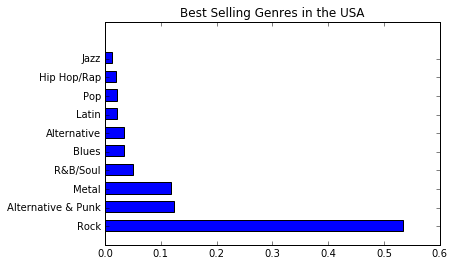

In [11]:
num_cols = best_selling_genres['genre']
bar_widths = best_selling_genres['%_of_sales']
bar_positions = np.arange(10) + 0.75
tick_positions = range(1,11)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.6)

ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_title('Best Selling Genres in the USA')

plt.show()

In the Schema above, the sells percentage of tracks in the Chinook store according to genres.
The results show that the three artists that should be added to the Chinook store first are:
- Red Tone - Punk
- Slim Jim Bites - Blues
- Meteor and the Girls - Pop

# Analyzing Employee Sales Performance

In [12]:
employee_sales_performance = '''

SELECT 
    e.first_name || " " || e.last_name name,
    SUM(i.total) total_sales,
    e.hire_date
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE e.title LIKE "sales support agent"
GROUP BY 1
ORDER BY 2 DESC;

'''
run_query(employee_sales_performance)

,name,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


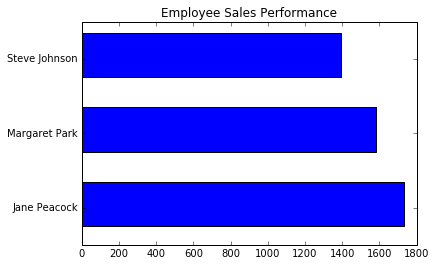

In [16]:
employee_sales = run_query(employee_sales_performance)

num_cols = employee_sales['name']
bar_widths = employee_sales['total_sales']
bar_positions = np.arange(3) + 0.75
tick_positions = range(1,4)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.6)

ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_title('Employee Sales Performance')

plt.show()

The schema above describe sales employee performance (sales in USD).
Steve Johnson is the least succesful sales agent, but that aligns with his hiring date. 


# Analyzing Sales by Country

In [14]:
xx = '''
WITH customer_invoice AS
(
SELECT 
    CASE
        WHEN (
                SELECT COUNT(*) 
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Other"
        ELSE c.country
        END AS country,
    COUNT(DISTINCT(c.customer_id)) as customers,
    SUM(i.total) total,
    COUNT(DISTINCT(i.invoice_id)) invoice_id    
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
)


SELECT 
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value    
FROM (SELECT 
    country,
    SUM(customers) customers,
    SUM(total) total_sales,
    SUM(total) / SUM(invoice_id) average_order,
    SUM(total) / SUM(customers) customer_lifetime_value,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
    END AS sort
FROM customer_invoice
GROUP BY country
ORDER BY sort ASC, total_sales DESC
);

'''
run_query(xx)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


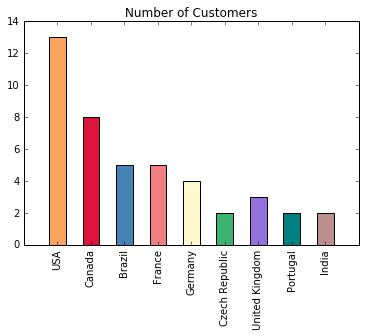

In [53]:
country_info = run_query(xx)
country_info = country_info[0:9]

num_cols = country_info['country']
bar_heights = country_info['customers']
bar_positions = np.arange(9) + 0.75
tick_positions = range(1,10)
colors = ['sandybrown', 'crimson', 'steelblue', 'lightcoral', 'lemonchiffon', 'mediumseagreen', 'mediumpurple', 'teal', 'rosybrown']


fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, 0.5, color=colors)

ax.set_xticks(tick_positions)
ax.set_xticklabels(num_cols, rotation=90)
ax.set_title("Number of Customers")

plt.show()

In [22]:
sales_vals = country_info['total_sales'][0:9]
country_labels = country_info['country'][0:9]

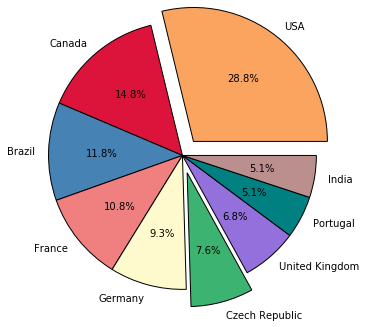

In [56]:
plt.axis("equal")
colors = ['sandybrown', 'crimson', 'steelblue', 'lightcoral', 'lemonchiffon', 'mediumseagreen', 'mediumpurple', 'teal', 'rosybrown']
plt.pie(sales_vals,labels=country_labels,radius=1.5, colors=colors, autopct='%0.1f%%', explode=[0.2,0,0,0,0,0.2,0,0,0])
plt.show()

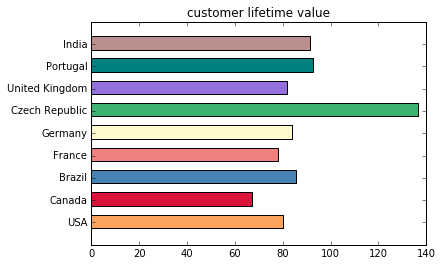

In [52]:

num_cols = country_info['country']
bar_widths = country_info['customer_lifetime_value']
bar_positions = np.arange(9) + 0.75
tick_positions = range(1,10)
colors = ['sandybrown', 'crimson', 'steelblue', 'lightcoral', 'lemonchiffon', 'mediumseagreen', 'mediumpurple', 'teal', 'rosybrown']


fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.6, color=colors)

ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_title('customer lifetime value')

plt.show()

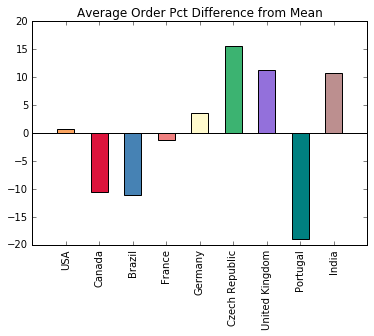

In [70]:
compare_to_avg = country_info
compare_to_avg['compare_to_avg'] = compare_to_avg['average_order'] * 100/ compare_to_avg['average_order'].mean() -100


num_cols = compare_to_avg['country']
bar_heights = compare_to_avg['compare_to_avg']
bar_positions = np.arange(9) + 0.75
tick_positions = range(1,10)
colors = ['sandybrown', 'crimson', 'steelblue', 'lightcoral', 'lemonchiffon', 'mediumseagreen', 'mediumpurple', 'teal', 'rosybrown']


fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, 0.5, color=colors)

ax.set_xticks(tick_positions)
ax.set_xticklabels(num_cols, rotation=90)
ax.set_title("Average Order Pct Difference from Mean")
ax.axhline(0, color='k')

plt.show()

The countries with the biggest potential (Based on the data) are:
- Czech Republic
- UK
- India

Since the amount of data from those countries is low, I would recommend testing the markets to get a larger sample size to analyze. 


# Albums vs Individual Tracks

In [36]:
full_album_purchase = '''
WITH invoice_one_track AS
(
SELECT 
    invoice_id,
    MIN(track_id) first_track_id
FROM invoice_line
GROUP BY 1
)

SELECT
    full_album_purchase,
    COUNT(invoice_id) no_of_invoices,
    CAST(COUNT(invoice_id) as Float) / (SELECT COUNT(*) FROM invoice) percent
FROM
(
SELECT
    iot.*,
    CASE
        WHEN
            (
            SELECT track_id from track
            WHERE album_id = (SELECT album_id FROM track
                              WHERE track_id = iot.first_track_id)
            
            EXCEPT
            
            SELECT track_id FROM invoice_line
            WHERE invoice_id = iot.invoice_id
            ) IS NULL
        AND
            (
            SELECT track_id FROM invoice_line
            WHERE invoice_id = iot.invoice_id
            
            EXCEPT
            
            SELECT track_id from track
            WHERE album_id = (SELECT album_id FROM track
                              WHERE track_id = iot.first_track_id)
            )IS NULL
            THEN "Yes"
            ELSE "No"
        END AS "full_album_purchase"
FROM invoice_one_track iot
)
GROUP BY full_album_purchase
;

'''
    
run_query(full_album_purchase)

,full_album_purchase,no_of_invoices,percent
0,No,500,0.814332
1,Yes,114,0.185668


Acccording to the data, only 18.5% of purchases are full albums, therefore I would recommend purchasing selected tracks from the record companies. Although there is a potential in losing one fifth of the revenue - There is a larger potential in lowering the payment for the records companies when buying only selected tracks.